# Transverse Field Ising Model  - Qiskit 1.X Tutorial
Based on https://www.nature.com/articles/s41586-023-06096-3

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

def generate_1d_tfim_circuit(num_qubits: int, num_trotter_steps: int, rx_angle: float, num_classical_bits: int=0, trotter_barriers: bool = False, layer_barriers: bool = False) -> QuantumCircuit:
    qc = QuantumCircuit(num_qubits, num_classical_bits)

    for _ in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

    return qc

def add_1d_tfim_trotter_layer(qc: QuantumCircuit, rx_angle: float, layer_barriers: bool = False) -> None:
    def add_Rzz_gate(control_qubit: int):
        qc.sdg([control_qubit, control_qubit+1])
        qc.append(SYGate, [control_qubit+1])
        qc.cx(control_qubit, control_qubit+1)
        qc.append(SYdgGate, [control_qubit+1])

    # Split up in this way to create two layers of gates where even qubits
    # apply the Rzz gate first
    for i in range(0, qc.num_qubits-1, 2):
        add_Rzz_gate(i)

    if layer_barriers:
        qc.barrier()

    for i in range(1, qc.num_qubits-1, 2):
        add_Rzz_gate(i)

    if layer_barriers:
        qc.barrier()
        
    # Apply rx gate to each qubit
    qc.rx(rx_angle, list(range(qc.num_qubits)))

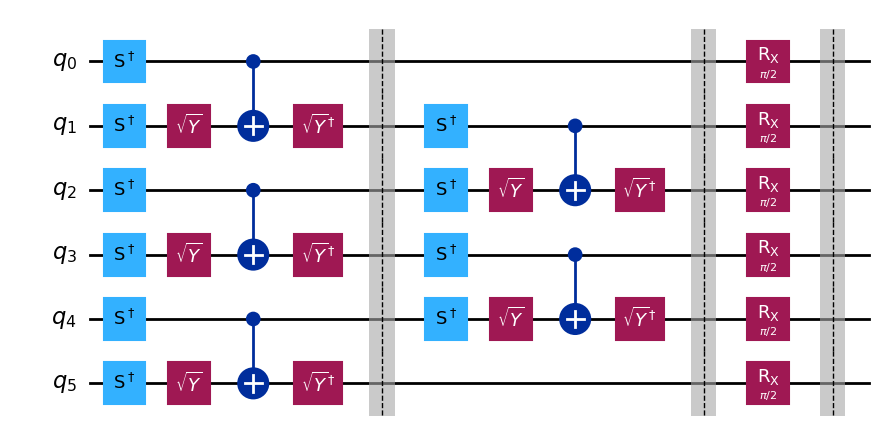

In [6]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw("mpl", fold=-1)

## Sampler Demo
Plot the probability of getting the all zero string when running the circuit forward then backwards to demonstrate the effect of noise as circuit depth increases

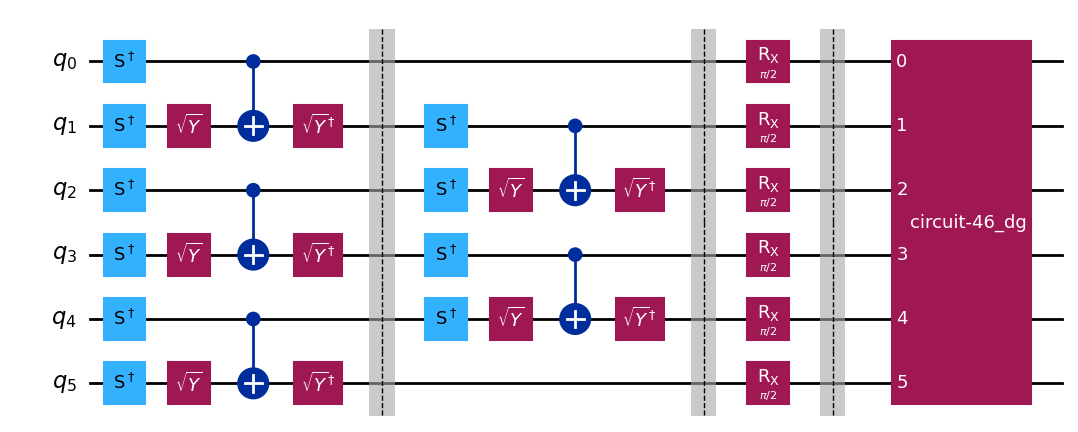

In [7]:
def append_mirrored_circuit(qc: QuantumCircuit) -> QuantumCircuit:
    mirrored_qc = qc.inverse(annotated=True)
    qc.append(mirrored_qc, mirrored_qc.qubits, mirrored_qc.clbits)
    return qc
qc = append_mirrored_circuit(qc)
qc.draw("mpl", fold=-1)

In [8]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, trotter_step, rx_angle, num_classical_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
    qc = append_mirrored_circuit(qc)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

## Optimize circuit

In [ ]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

BACKEND_NAME = "ibm_fez"
service = QiskitRuntimeService() # Details saved from cloud_connect_testing notebook
backend = QiskitRuntimeService().backend(BACKEND_NAME)

transpiled_qc_list = transpile(qc_list, backend=backend, optimization_level=1)

## Execute

In [62]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(transpiled_qc_list)
print(job.job_id())

d4rh8b4fitbs739hvla0


In [9]:
job_id = "d4rh8b4fitbs739hvla0"
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probability_list.append(0)

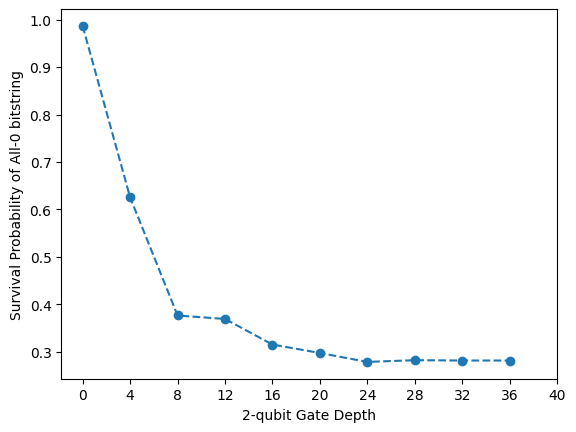

In [10]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, "--o")
plt.xlabel("2-qubit Gate Depth")
plt.ylabel("Survival Probability of All-0 bitstring")
plt.xticks(np.arange(0, 44, 4))
plt.show()

## Estimator

In [11]:
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

rx_angle = Parameter("rx_angle")
qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps=2, rx_angle=rx_angle)

middle_index = num_qubits // 2
observable = SparsePauliOp("I" * middle_index + "Z" + "I" * (middle_index-1))

## Optimize Circuit

In [65]:
transpiled_qc = transpile(qc, backend=backend, optimization_level=1)
observable = observable.apply_layout(transpiled_qc.layout)

## Execute

In [ ]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
rx_angle_steps = 12
trotter_steps = 2
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, rx_angle_steps)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = EstimatorV2(backend, options=options)

job = estimator.run([(transpiled_qc, observable, rx_angle_list)])
print(job.job_id())

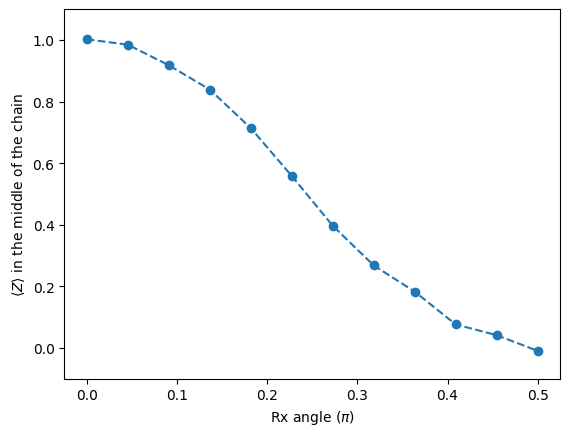

In [14]:
job_id = "d4rhfont3pms739880j0"
job = service.job(job_id)

exp_val_list = job.result()[0].data.evs
plt.plot(rx_angle_list / np.pi, exp_val_list, "--o")
plt.xlabel(r"Rx angle ($\pi$)")
plt.ylabel(r"$\langle Z \rangle$ in the middle of the chain")
plt.ylim(-0.1, 1.1)
plt.show()